# Get Rich ~~or Die Tryin'~~ with Data Science (maybe...)

Retirement. Investing. Stocks. Day trading. Index funds. Scalping. 

Oh, my.

The world of finance is a big one. And even though it's not really taught in schools any more (at least here in the States), at some point, just about everyone hears a lot of those above terms. Some even try to take on the challenge of managing their own portfolios and other make careers out of managing the portfolios of other people (lookin' at you, Warren Buffett).

And while many see success, others find dismal failures.

*raises hand*

In this day and age, "algorithmic trading" while a bit of a buzzword, has changed things. It boils down to letting computers trade stocks and other equities for us. Letting a computer trade, supposedly, confers some kind of advantage that in theory should make a trader more profitable.

And so, we're going to set out to test that idea:

## Is it possible to trade with a computer and beat the average market return of 10%?

And we're going to add one more twist: we will try to do it with only one, single equity.

In order to test that we will examine one of the most popular stocks in the past few years: Tesla.

Data comes from https://www.kaggle.com/ysthehurricane/tesla-stock-data-20162021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('TSLA.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,183.274022,187.265251,178.941224,183.351102,183.351102,4.441050e+07
std,227.979867,232.845126,222.443374,227.987027,227.987027,3.035737e+07
min,36.220001,36.945999,35.397999,35.793999,35.793999,8.297500e+06
25%,54.985001,55.930001,53.929001,54.994501,54.994501,2.478255e+07
50%,66.602002,67.950001,65.445999,66.756000,66.756000,3.498150e+07
75%,165.516998,168.243504,161.504005,163.856503,163.856503,5.211238e+07
max,891.380005,900.400024,871.599976,883.090027,883.090027,3.046940e+08


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1253,2021-08-09,710.169983,719.030029,705.130005,713.760010,713.760010,14715300
1254,2021-08-10,713.989990,716.590027,701.880005,709.989990,709.989990,13432300
1255,2021-08-11,712.710022,715.179993,704.210022,707.820007,707.820007,9800600
1256,2021-08-12,706.340027,722.799988,699.400024,722.250000,722.250000,17459100
1257,2021-08-13,723.710022,729.900024,714.340027,717.169983,717.169983,16698900


So near 20x increase in stock value in 5 years. Not too shabby, Elon. At this point, since hindsight is 20/20 and all that, we could say that "Yes, buy \$50k worth of stock and then in 5 years, you'll be a millionaire."

But that's boring.

Instead, we are going to see if there is a way to systematically trade this one stock in a way that maximizes returns and (hopefully) beats the market average.

Taking another look at the data, Close and Adj Close look to be nearly the same...

In [7]:
sum(df['Close'] - df['Adj Close'])

0.0

Well that's weird. Either there is some painstaking balance across 1200+ rows of data, or these columns are indeed the same. So let's drop the Adj Close column.

In [8]:
df = df.drop(columns=['Adj Close'])
df

,Date,Open,High,Low,Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500
...,...,...,...,...,...,...
1253,2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300
1254,2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300
1255,2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600
1256,2021-08-12,706.340027,722.799988,699.400024,722.250000,17459100


In [9]:
# Time-series analysis is a pretty good
# way to look at stock data, but we need
# to set the date column as the index first.

df['Date'] = pd.to_datetime(df['Date']) # helps with the x-axis tick marks
df.set_index('Date',inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500
2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500
2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500
2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500
2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500
...,...,...,...,...,...
2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300
2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300
2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600


In [10]:
# The next charts were kind of hard to read 
# so I tried to find an easier to read style

# ['Solarize_Light2', '_classic_test_patch', 'bmh', 
#  'classic', 'dark_background', 'fast', 'fivethirtyeight', 
#  'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 
#  'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 
#  'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 
#  'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 
#  'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.style.use('seaborn-talk')

In [11]:
from datetime import datetime
today = datetime.today()
this_year = today.year
this_year

2021

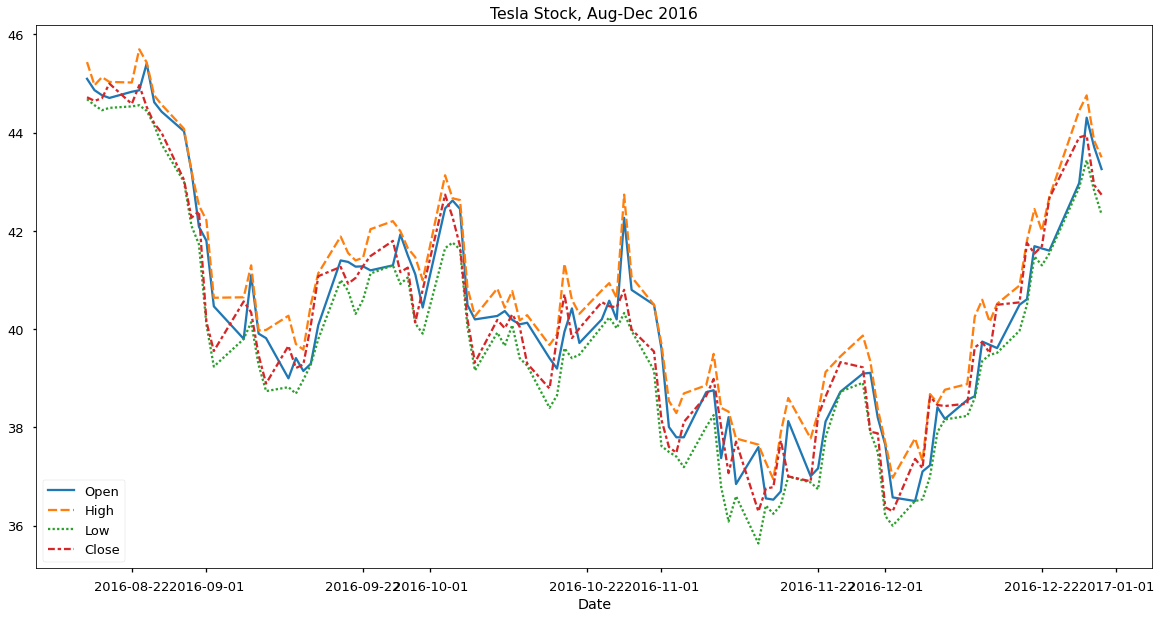

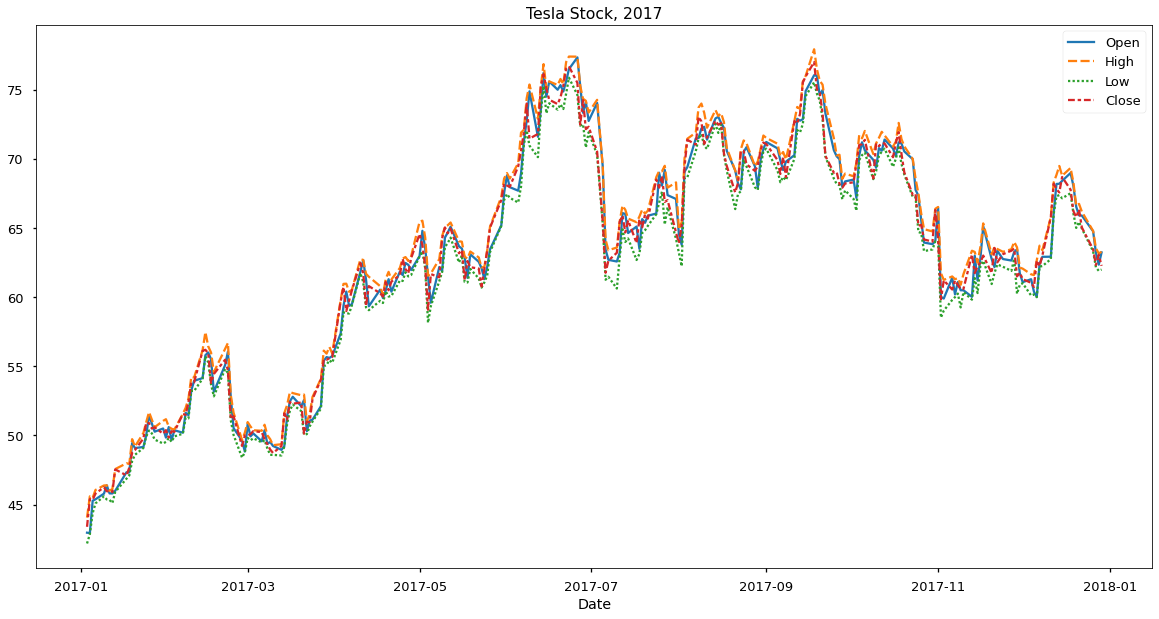

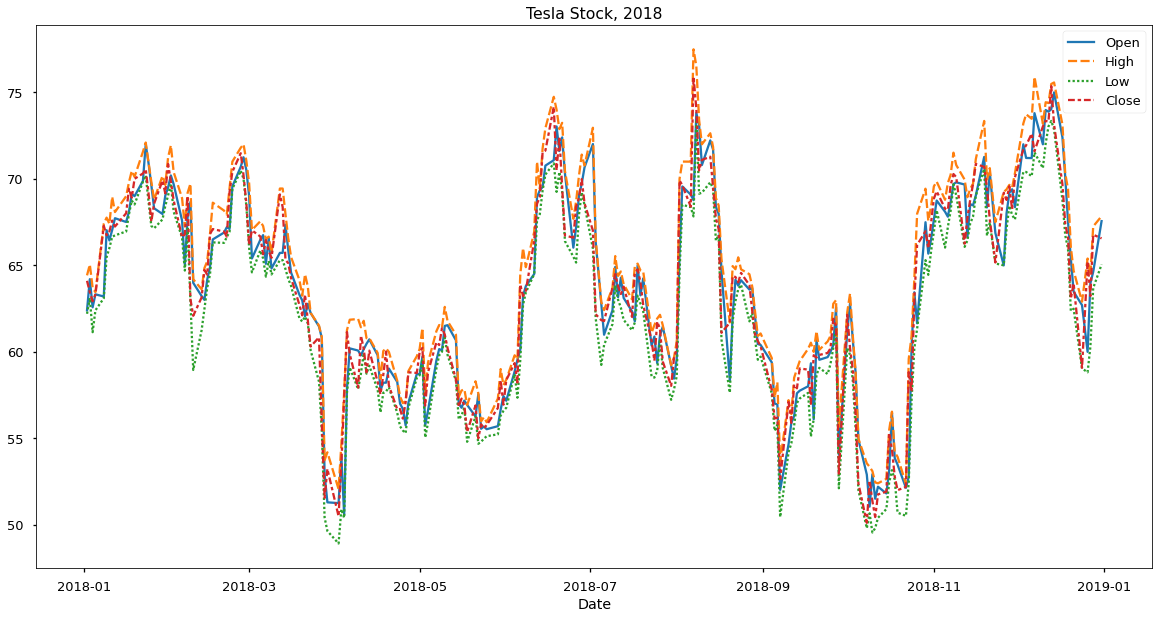

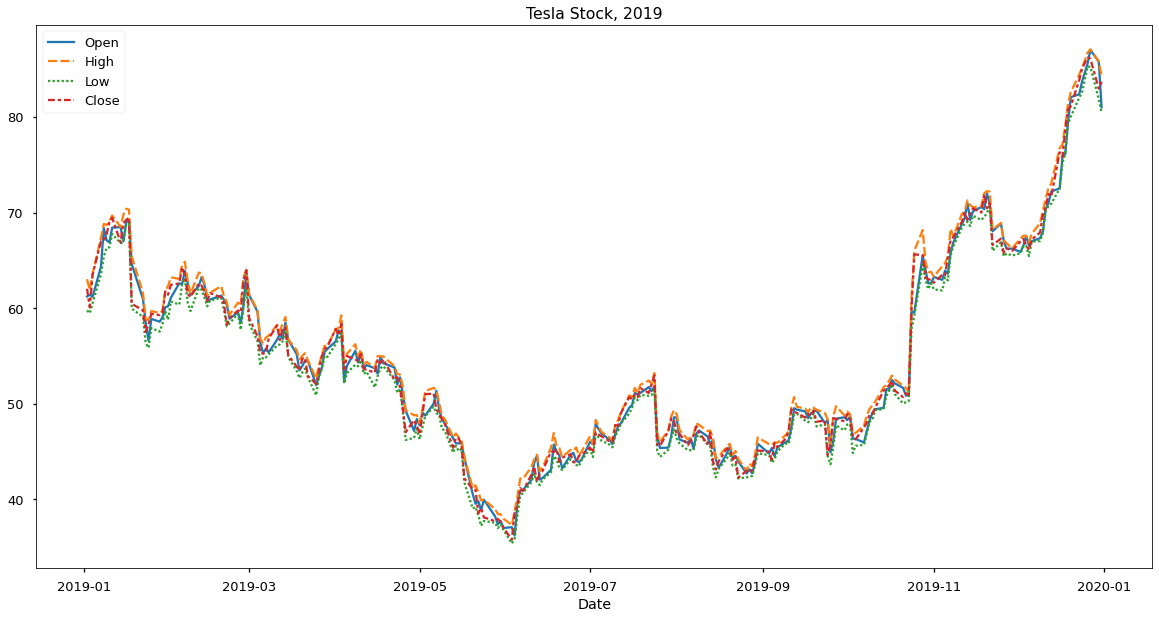

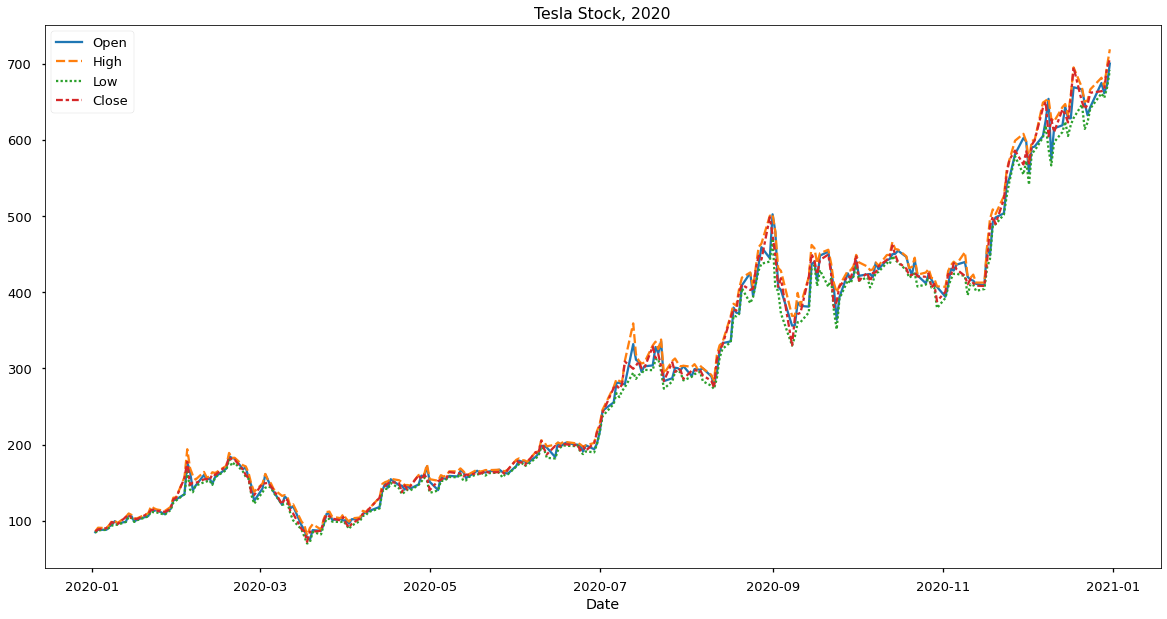

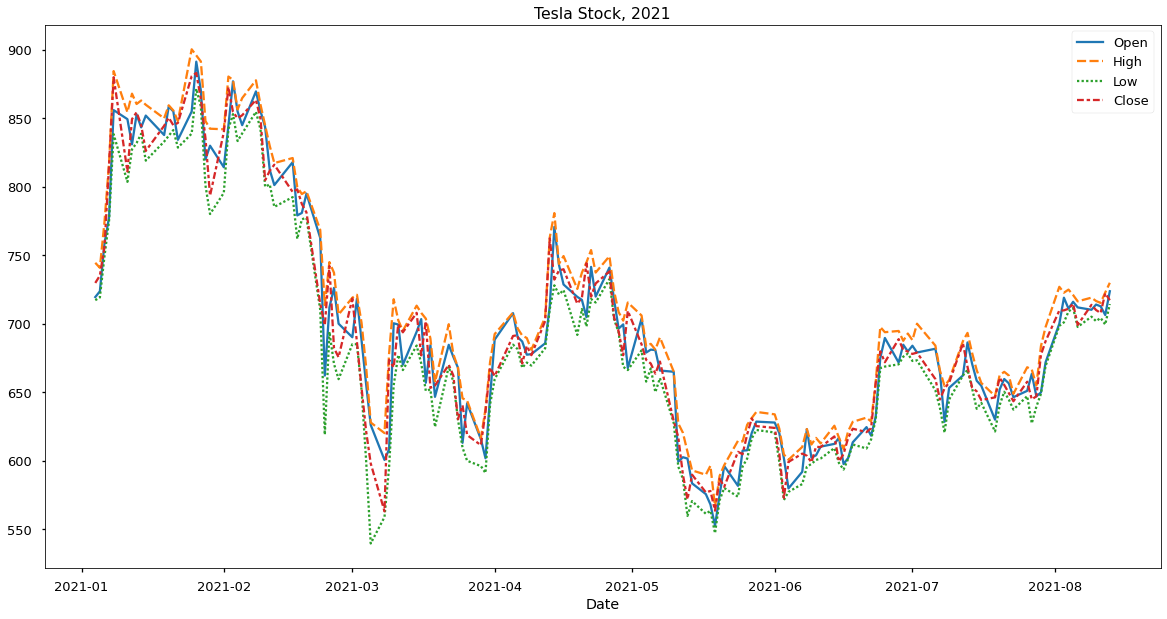

In [12]:
no_vol = df.drop(columns=['Volume'])

for year in range(2016,this_year+1):
    plt.figure(figsize=(20,10))
    if year == 2016:
        sns.lineplot(data=no_vol.loc['2016-08-16':'2016-12-31'])
        plt.title('Tesla Stock, Aug-Dec 2016')
    elif year == this_year+1:
        sns.lineplot(data=no_vol.loc[f'{this_year}-01-01':])
        plt.title(f'Tesla Stock, YTD {this_year}')
    else:
        sns.lineplot(data=no_vol.loc[f'{year}-01-01':f'{year}-12-31'])
        plt.title(f'Tesla Stock, {year}')
    plt.show()

## Some observations

Tesla's stocks have long runs of climbing followed by short (and sometimes long) runs of falling. If we can "predict" when these runs change to upward trends *and* downward trends, we can minimize losses while maximizing gains.

One of the simplest ways to do that is to use Exponential Moving Averages (EMAs). Using a shorter EMA and a longer EMA, when the shorter one crosses over the longer one, that will indicate a buy signal. When the longer one crosses over the shorter one, that will be a sell signal.

If that trend holds up, then the next step will be to predict when those crosses will occur.

In [13]:
def plot_time_series(extra_data1,extra_data2,label1,label2,label3,col,title):
    plt.figure(figsize=(20,10))
    sns.lineplot(data=extra_data1,label=label1,legend=False,linewidth=1)
    sns.lineplot(data=extra_data2,label=label2,legend=False,linewidth=1)
    sns.lineplot(data=data[col],label=label3,legend=False,linewidth=1)
    plt.title(title)
    plt.legend()
    plt.show()

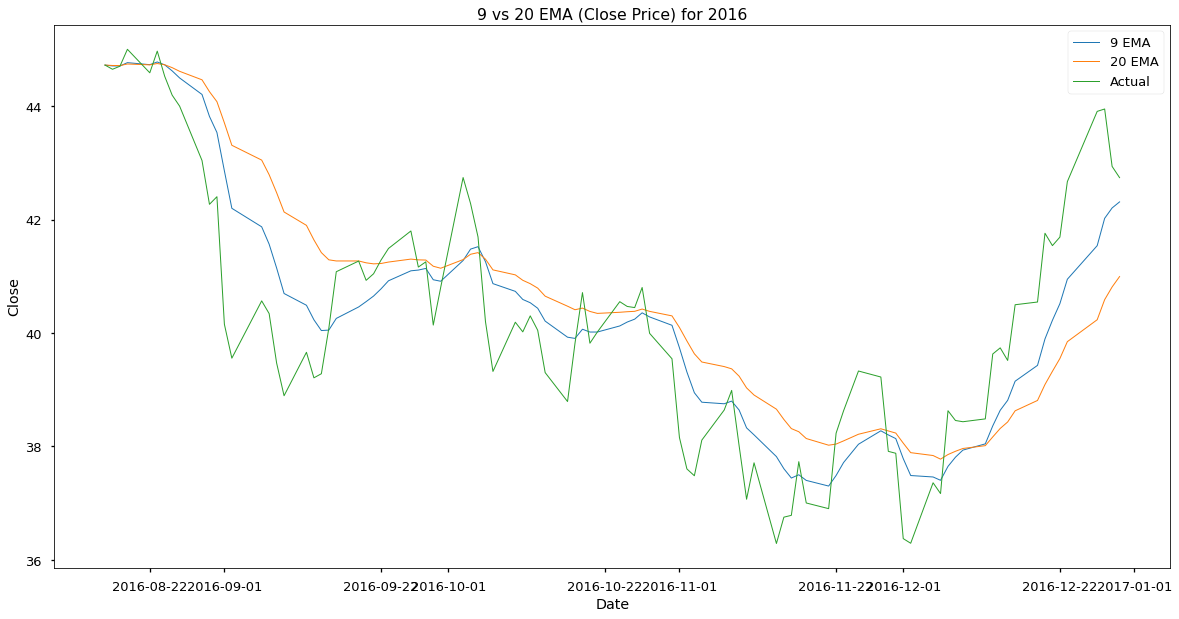

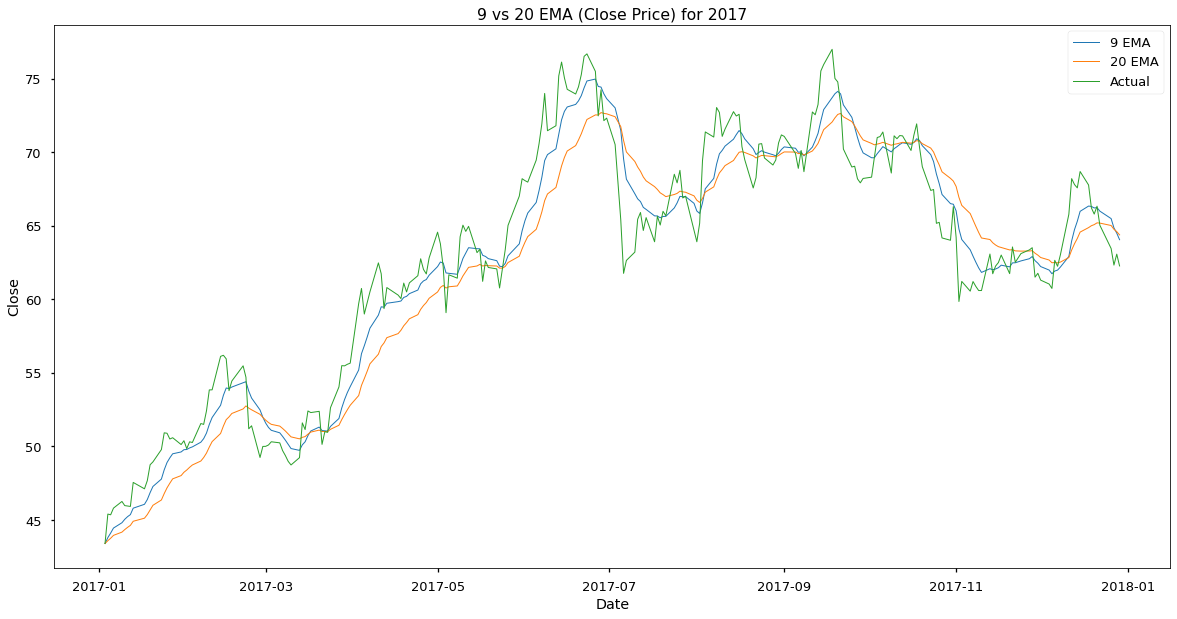

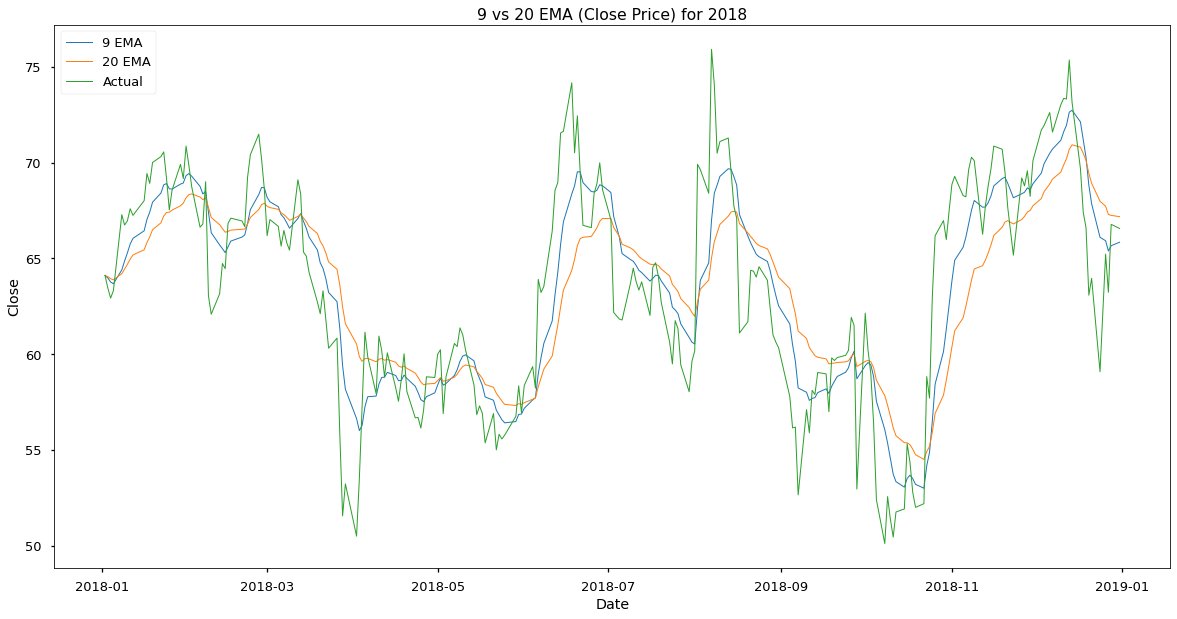

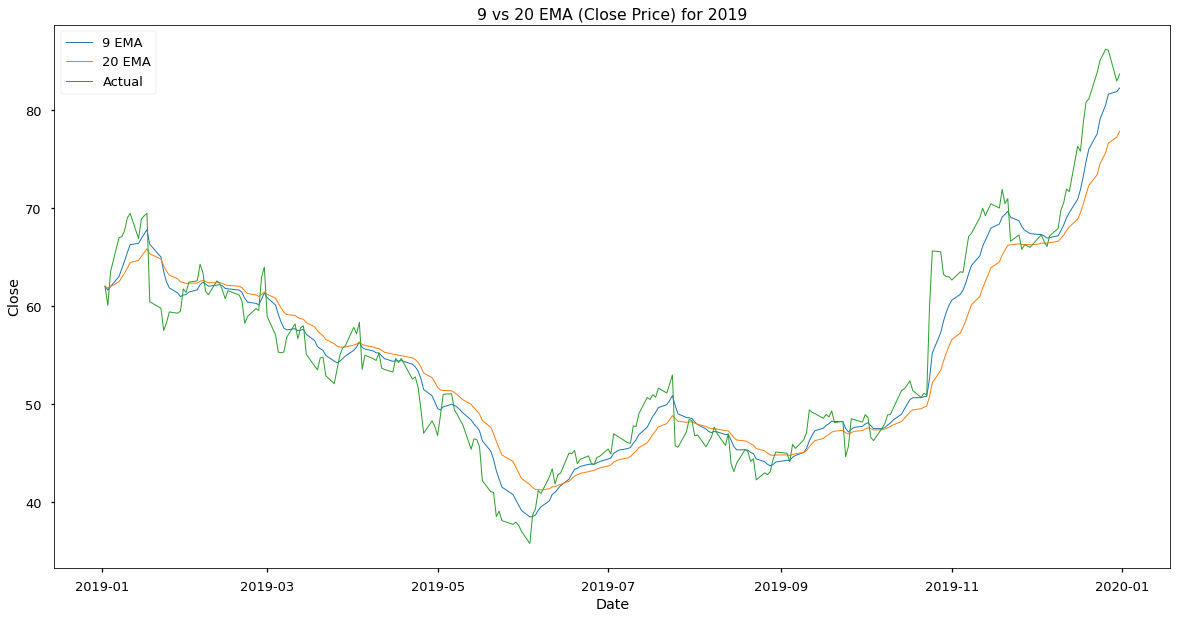

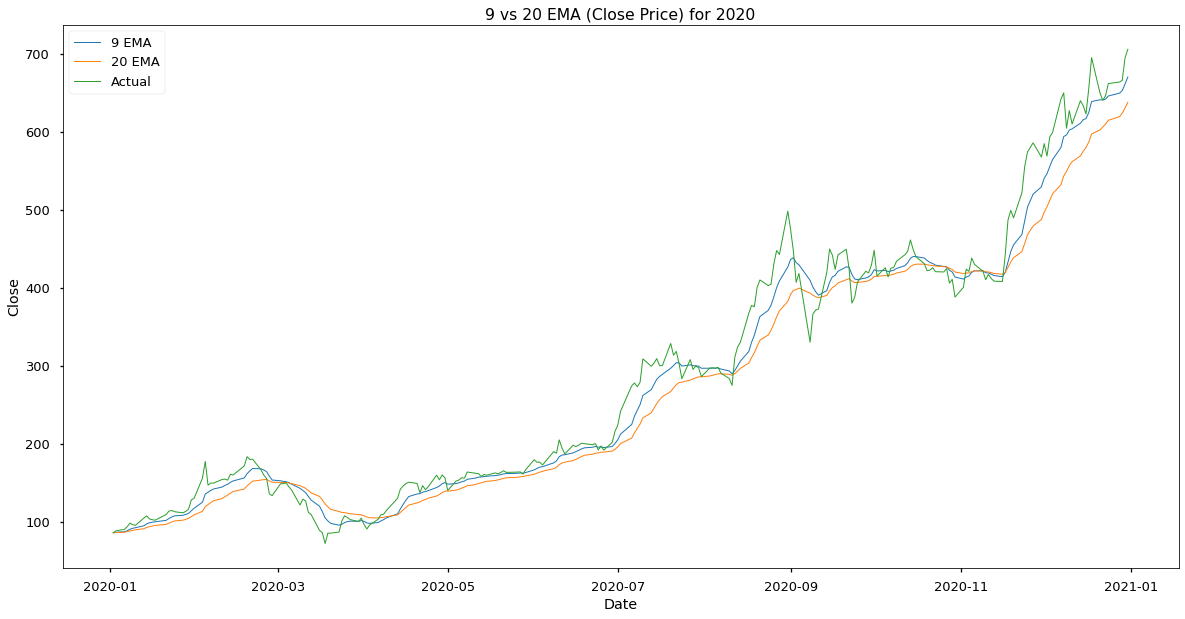

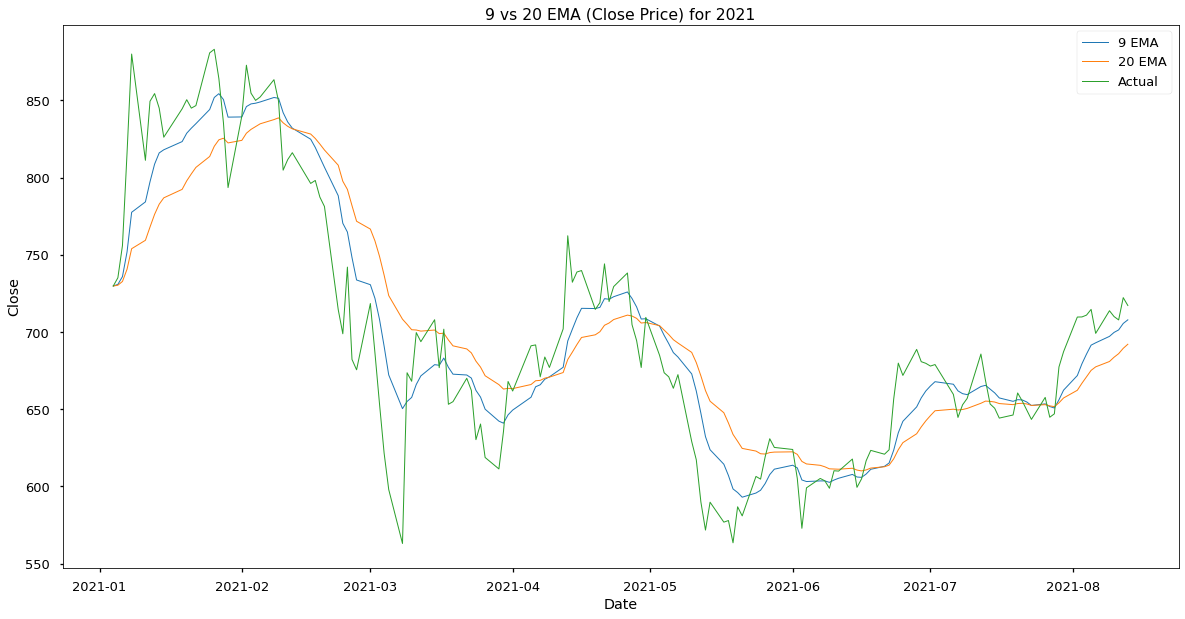

In [14]:
# EMA's and when they cross are a pretty
# simple yet popular way people trade stocks.
# When the 9 is over the 20, that's a buy signal.
# When the 20 is over the 9, that's a sell signal.
# Let's see how it looks.

for year in range(2016,this_year+1):
    if year == 2016:
        data = no_vol.loc['2016-08-16':'2016-12-31']
        EMA_9 = data['Close'].ewm(span=9, adjust=False).mean()
        EMA_20 = data['Close'].ewm(span=20, adjust=False).mean()
        plot_time_series(EMA_9,
                         EMA_20,
                         '9 EMA', 
                         '20 EMA', 
                         'Actual',
                         'Close',
                         '9 vs 20 EMA (Close Price) for 2016')
    elif year == this_year+1:
        data = no_vol.loc[f'{this_year}-01-01':]
        EMA_9 = data['Close'].ewm(span=9, adjust=False).mean()
        EMA_20 = data['Close'].ewm(span=20, adjust=False).mean()
        plot_time_series(EMA_9,
                         EMA_20,
                         '9 EMA', 
                         '20 EMA', 
                         'Actual',
                         'Close',
                         f'9 vs 20 EMA (Close Price) for {this_year}')
    else:
        data = no_vol.loc[f'{year}-01-01':f'{year}-12-31']
        EMA_9 = data['Close'].ewm(span=9, adjust=False).mean()
        EMA_20 = data['Close'].ewm(span=20, adjust=False).mean()
        plot_time_series(EMA_9,
                         EMA_20,
                         '9 EMA', 
                         '20 EMA', 
                         'Actual',
                         'Close',
                         f'9 vs 20 EMA (Close Price) for {year}')


## At a glance...

Except for some blips in 2016 and 2017, using these trends, just about every trade looks to be successful!

But did we beat the 10% average?

At the time of writing this, the data spans roughly 5 years (Aug 2016 to Aug 2021). At a 10% return, and assuming, let's say an investment portfolio of $50,000...

In [15]:
# Adapted from https://www.geeksforgeeks.org/python-program-for-compound-interest/
# Python3 program to find compound
# interest for given values.

def compound_interest(principle, rate, time):

    # Calculates compound interest
    Amount = principle * (pow((1 + rate / 100), time))
    CI = Amount + principle
    print("New balance is", CI)

# Driver Code
compound_interest(50*1000, 10, 5)

# This code is contributed by Abhishek Agrawal.


New balance is 130525.50000000003


So in 5 years, \\$50,000 turns into \\$130,525. That seems pretty decent.

In [16]:
# First we define the EMAs and add them to the df.

EMA_9 = df['Close'].ewm(span=9, adjust=False).mean()
EMA_20 = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_9'] = EMA_9
df['EMA_20'] = EMA_20
# I'm also re-adding a psedo-index for later
df['Row'] = range(0,len(df-1))
df

,Open,High,Low,Close,Volume,EMA_9,EMA_20,Row
Date,,,,,,,,
2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500,44.722000,44.722000,0
2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500,44.707200,44.714952,1
2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500,44.706160,44.713719,2
2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500,44.764928,44.740984,3
2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500,44.729142,44.726223,4
...,...,...,...,...,...,...,...,...
2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300,697.147998,680.874279,1253
2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300,699.716396,683.647204,1254
2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600,701.337118,685.949376,1255


In [17]:
# We're going to create a new column, "Signal",
# that looks for where the crosses happen.
# There will be a 1 for a buy signal, and a 2
# for a sell signal. The first row will be 0 
# because there's nothing really to compare it to.
df['Signal'] = 0

for row in range(len(df)):
    if df.loc[df['Row'] == row, 'EMA_9'].values[0] > df.loc[df['Row'] == row, 'EMA_20'].values[0]:
        df.loc[df['Row'] == row, 'Signal'] = 1
    elif df.loc[df['Row'] == row, 'EMA_9'].values[0] < df.loc[df['Row'] == row, 'EMA_20'].values[0]:
        df.loc[df['Row'] == row, 'Signal'] = 2
    else:
        pass
        
df

,Open,High,Low,Close,Volume,EMA_9,EMA_20,Row,Signal
Date,,,,,,,,,
2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500,44.722000,44.722000,0,0
2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500,44.707200,44.714952,1,2
2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500,44.706160,44.713719,2,2
2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500,44.764928,44.740984,3,1
2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500,44.729142,44.726223,4,1
...,...,...,...,...,...,...,...,...,...
2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300,697.147998,680.874279,1253,1
2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300,699.716396,683.647204,1254,1
2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600,701.337118,685.949376,1255,1


In [18]:
# Whenever a cross happens, for a buy, we'll use the 
# closing price (since all the analysis used closing price)
# that day to set an entry.

# Whenever a cross happens, for a sell, we'll use the 
# closing price (since all the analysis used closing price)
# that day to set an exit.

# Then we will have a difference (positive or negative)
# that can be used to see if an account would grow or shrink
# trading this one equity. For the sake of this exercise, 
# we are going to trade 100% of the account value, although
# normally that wouldn't happen.

import math

position = 'closed'
entry = 0
exit = 0
shares = 0
account_val = 50000

for row in range(len(df)):
    signal = df.loc[df['Row'] == row, 'Signal'].values[0]

    if signal == 1 and position == 'closed':
        entry = df.loc[df['Row'] == row, 'Close'].values[0]
        position = 'open'
        shares = math.floor(account_val / entry)
        print(f"Row: {row}")
        print(f"Entered at {entry} with {shares} shares.")
        print("===")
    elif signal == 2 and position == 'open':
        exit = df.loc[df['Row'] == row, 'Close'].values[0]
        position = 'closed'
        profit_loss = (exit - entry) * shares
        print(f"Row: {row}")
        print(f"Exited at {exit}. P/L: {profit_loss}")
        account_val += profit_loss
        print(f"Current balance: {account_val}")
        print("===")
        entry = 0
        exit = 0
        shares = 0

print(f"Final balance: {account_val}")


Row: 3
Entered at 45.0 with 1111 shares.
===
Row: 6
Exited at 44.523998. P/L: -528.8382220000012
Current balance: 49471.161778
===
Row: 34
Entered at 42.282001 with 1170 shares.
===
Row: 36
Exited at 40.200001. P/L: -2435.940000000001
Current balance: 47035.221778
===
Row: 82
Entered at 38.486 with 1222 shares.
===
Row: 135
Exited at 50.004002. P/L: 14074.998444000003
Current balance: 61110.220222
===
Row: 147
Entered at 52.299999 with 1168 shares.
===
Row: 222
Exited at 65.417999. P/L: 15321.823999999993
Current balance: 76432.044222
===
Row: 244
Entered at 71.382004 with 1070 shares.
===
Row: 268
Exited at 68.68. P/L: -2891.1442799999872
Current balance: 73540.899942
===
Row: 269
Entered at 72.737999 with 1011 shares.
===
Row: 280
Exited at 69.050003. P/L: -3728.563955999998
Current balance: 69812.335986
===
Row: 296
Entered at 71.93 with 970 shares.
===
Row: 298
Exited at 69.019997. P/L: -2822.702910000003
Current balance: 66989.633076
===
Row: 333
Entered at 65.781998 with 1018 sha

## Final observations

After a bit of an initial losing streak (more on this in a second), Elon gets his business in order and turns it all around. And it looks like that's good news for us!

Previously, we saw that trading something like index funds and getting a safe, consistent return of 10%...

After 5 years, \\$50,000 would turn into \\$130,000. (roughly a 160% return, not bad)

Using a system (albeit, a flawed one) and some data, over that same 5 years, we turned \\$50,000 into just shy of \\$600,000.

So instead of that 160%, we were able to net a 1,000%+ return!

Now, that initial losing streak would probably deter a lot of investors/day-traders. And it should. But here's the thing.

Elon is the type that likes to take risks, and he did just that, and quite a bit, around Tesla's IPO and beyond. 

So while this technical analysis on it's own seems to be quite profitable, coupled with fundamental analysis (watching the news for some of his publicity stunts) and estimating their effects on the stock, and coming up with some better money management (using the ENTIRE balance of the account to fund the trade is a no-no)...

These things would most likely help to mitigate losses even further, which would drive that return even higher into the sky.